# Filer, Burchardt & van Rensburg (2021) <br /> **Wallum sedgefrog and the eastern sedgefrog**

**Paper:** Filer, A., Burchardt, L. S., & van Rensburg, B. J. (2021). Assessing acoustic competition between sibling frog species using rhythm analysis. *Ecology and Evolution 11*, 8814– 8830. DOI: [10.1002/ece3.7713](https://doi.org/10.1002/ece3.7713).

**Dataset:** Filer, Alannah and Burchardt, Lara S.(2021). Assessing acoustic competition between sibling frog species using rhythm analysis. The University of Queensland. Data Collection. DOI: [10.14264/6c4553a](https://doi.org/10.14264/6c4553a)

**Dataset License:** [Permitted re-use with acknowledgement](https://guides.library.uq.edu.au/deposit-your-data/license-reuse-with-acknowledgement): "acknowledge any re-use of this dataset in any research outputs where reliance is made upon it, including conference papers and published research papers."

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from rhythmplot import *

# Directory to all the raw data (included in this repository)
DATA_DIR = '../data/filer2021'
ORIGINAL_DATA_DIR = f'{DATA_DIR}/original-data'

# Function to save figures: you can easily toggle this on/off globally
savefig = get_figure_saver(group='filer2021', save_pdf=False, save_png=False)

## Preprocessing

**Download the data** via https://espace.library.uq.edu.au/view/UQ:6c4553a or https://doi.org/10.14264/6c4553a. The file `IOI_and_call_sequence_data.xlsx` was not directly parseable by Pandas, so I manually exported it to `filer2021.csv` using Apple Numbers.

The dataset contains empty rows that separate the 41 recordings, like this:

```csv
start,end,species,recording,sequence,ioi,situation
22.168306,22.604909,WSF,1,WSF 1,9,973719,alone
...
541.629465,542.222538,WSF,1,WSF 2,13,773171,alone,
555.434182,555.995709,WSF,1,WSF 2,30,292142,alone,
585.949674,586.287851,WSF,1,WSF 2,,alone,
,,,,,,
28.03354,28.71222,WSF,2,WSF 1,4,4489,alone,
32.435843,33.16112,WSF,2,WSF 1,3,57168,alone,
36.207076,36.7328,WSF,2,WSF 1,2,853495,alone,
```
The column `ioi` is at least in the beginning computed as `end[1:] - end[:-1]`. Later, with a `competitor present` we see something like this:

```csv
62.594882,62.862776,WSF,22,,,
63.006254,63.395554,WSF,22,,,
63.501908,63.953415,WSF,22,,,
64.180172,64.398902,ESF,22,ESF 3,0.631106,competitor present
64.760107,65.030008,ESF,22,ESF 3,1.030438,competitor present
65.758439,66.060446,ESF,22,ESF 3,0.737460999999996,competitor present
66.625331,66.797907,ESF,22,ESF 3,0.950171000000012,competitor present
67.538378,67.748078,ESF,22,ESF 3,0.312040999999994,competitor present
67.891557,68.060119,ESF,22,ESF 3,4.863229,competitor present
72.532042,72.923348,ESF,22,ESF 3,,competitor present
73.332714,73.812315,WSF,22,,,
74.279875,74.761482,ESF,22,,,
76.652794,76.751122,ESF,22,,,
77.377211,77.453465,ESF,22,,,
77.845775,78.178886,WSF,22,,,
78.538085,78.90832,WSF,22,,,
79.724042,79.944779,ESF,22,ESF 4,1.398667,competitor present
81.253145,81.343446,ESF,22,ESF 4,0.847830000000002,competitor present
82.037763,82.191276,ESF,22,ESF 4,2.02275,competitor present
84.0866,84.214026,ESF,22,ESF 4,0.586957999999996,competitor present
84.51804,84.800984,ESF,22,ESF 4,0.106354999999994,competitor present
84.81152,84.907339,ESF,22,ESF 4,1.213048,competitor present
85.834433,86.120387,ESF,22,ESF 4,0.305018000000004,competitor present
86.261859,86.425405,ESF,22,ESF 4,1.176928,competitor present
87.186946,87.602333,ESF,22,ESF 4,0.388294999999999,competitor present
87.776915,87.990628,ESF,22,ESF 4,1.933452,competitor present
89.766555,89.92408,ESF,22,ESF 4,,competitor present
90.380604,90.657528,WSF,22,,,
90.839134,91.097998,ESF,22,,,
90.903348,91.349838,WSF,22,,,,
```

As the authors explain, 
> The call tags were exported to a csv file where sequences were then identified using a set protocol; sequences had to contain at least five sequential uninterrupted calls from the same species and contain no periods of silence >50 s between calls. Calls in a single sequence are most likely uttered by multiple individuals.

In [2]:
df = pd.read_csv(f'{ORIGINAL_DATA_DIR}/filer2021.csv', delimiter=";", decimal=",").iloc[:, :-1]
df.columns = [
    'start', # Start time in seconds
    'end', # Start time in seconds
    'species', # WSF = Wallum sedgefrog, ESF = eastern sedgefrog
    'recording', # some identifier (1–41, can be empty)
    # sequence within the recording: >5 uninterrupted calls from one species; silences <50ms
    # Starts with the species code: WSF/ESF
    'sequence', 
    'ioi', # in this case end-to-end (!) intervals in seconds
    'situation' # 'alone', nan, 'competitor present'
]

# remove space after columns
df['situation'] = df['situation'].str.strip()
assert len(pd.unique(df['situation'])) == 3
df['sequence'] = df['sequence'].str.strip()
df['species'] = df['species'].str.strip()

# Drop empty rows
empty_rows = df[df.isna().all(axis=1)].index
df = df.drop(index=empty_rows)

In [3]:
intervals = []
species = []
situations = []
sequences = []
seq_num = 1
for recording in pd.unique(df['recording']):
    subset = df.query(f'recording == {recording}')
    for seq in subset['sequence'].dropna().unique():
        sequence = subset.query(f'sequence=="{seq}"')
        assert len(sequence) >= 5

        ioi = sequence['ioi'].values
        
        # Make sure sequences always end with np.isnan (fixes only 3 cases)
        if np.isnan(ioi[0]):
            ioi = ioi[1:]
        if not np.isnan(ioi[-1]):
            ioi = np.r_[ioi, np.nan]
        assert not np.isnan(ioi[0])
        assert np.isnan(ioi[-1])
        intervals.extend(ioi)

        assert len(sequence['species'].dropna().unique()) == 1
        spec = sequence['species'].dropna().unique()[0]
        species.extend([spec] * (len(ioi) - 1))
        species.append(np.nan)

        assert len(sequence['situation'].dropna().unique()) <= 1
        sit = sequence['situation'].dropna().unique()
        sit = sit[0] if len(sit) == 1 else np.nan
        situations.extend([sit] * (len(ioi) - 1))
        situations.append(np.nan)

        sequences.extend([seq_num] * (len(ioi) - 1))
        sequences.append(np.nan)
        seq_num += 1

assert len(intervals) == len(species)
assert len(situations) == len(species)
assert len(sequences) == len(species)

intervals_df = pd.DataFrame(
    [intervals, species, situations, sequences], 
    index=['interval', 'species', 'situation', 'sequence']).T

# intervals_df.to_csv(f'{DATA_DIR}/filer2021-data.csv', index=False)
# save_intervals(intervals, 'filer2021', 'filer2021')

## Plot

In [4]:
# We need more than just the intervals, so load the csv file
intervals_df = pd.read_csv(f'{DATA_DIR}/filer2021-data.csv')

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


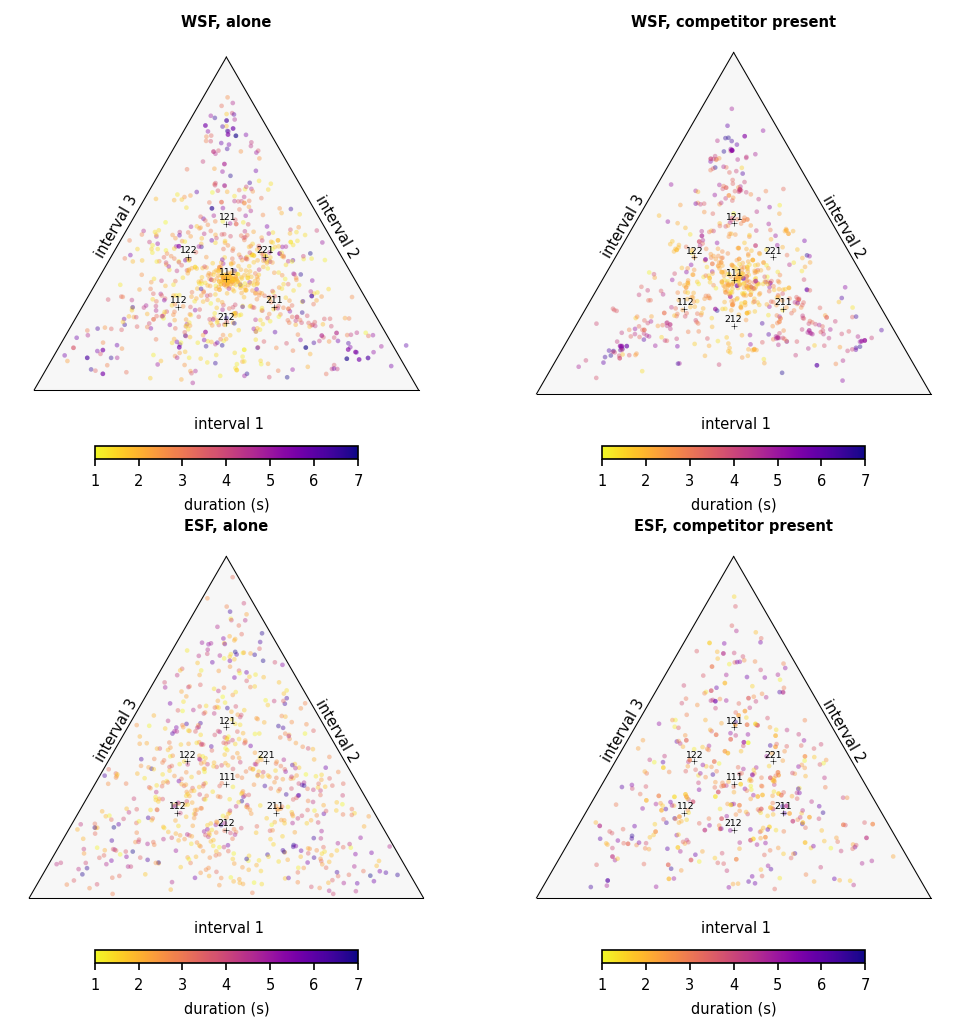

In [5]:
def show_subset(subset, ax, cbar=True, **kwargs):
    intervals = separate_sequences(subset)['interval'].values
    motifs, duration = normalize(ngram_motifs(intervals, length=3))
    ternary_motif_plot(motifs, duration, 
        ratio_kws=dict(factors=[1, 2]), 
        cbar=cbar,
        ax=ax, 
        **defaults(kwargs, scatter_kws=dict(s=5, alpha=.4)))

def show_row(axs, species="WSF", title=False, **kwargs):
    if title: axs[0].set_title(f'{species}, alone', fontsize=7, fontweight='bold')
    subset = intervals_df.query(f'species=="{species}" and situation=="alone"')
    show_subset(subset, ax=axs[0], **kwargs)

    if title: axs[1].set_title(f'{species}, competitor present', fontsize=7, fontweight='bold')
    subset = intervals_df.query(f'species=="{species}" and situation=="competitor present"')
    show_subset(subset, ax=axs[1], **kwargs)


def compare_conditions(**kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    show_row(axs[0, :], 'WSF', title=True, **kwargs)
    show_row(axs[1, :], 'ESF', title=True, **kwargs)

compare_conditions(min_dur=1, max_dur=7)
savefig('all-conditions')

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


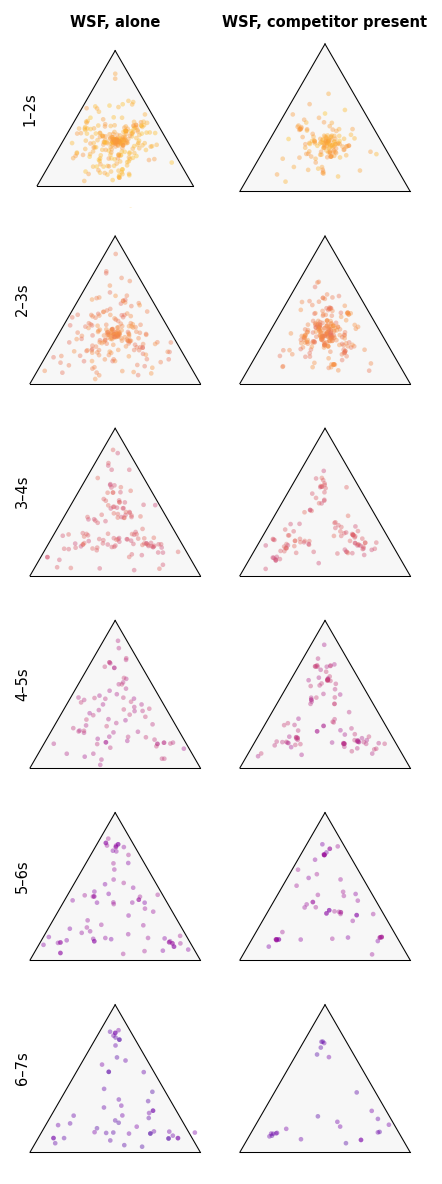

In [6]:
from matplotlib.colors import Normalize
def ylabel(label, ax):
    ax.text(0, 30, label, ha='right', va='center',  rotation=90, fontsize=7)

def compare_tempo_ranges(**kwargs):
    norm = Normalize(0, 8)
    kws = dict(norm=norm, plot_kws=dict(labels=False), ratios=False, cbar=False)
    fig, axs = plt.subplots(6, 2, figsize=(3, 8), tight_layout=True)
    ylabel('1–2s', axs[0, 0])
    show_row(axs[0, :], min_dur=1, max_dur=2, title=True, **kws)
    ylabel('2–3s', axs[1, 0])
    show_row(axs[1, :], min_dur=2, max_dur=3, **kws)
    ylabel('3–4s', axs[2, 0])
    show_row(axs[2, :], min_dur=3, max_dur=4, **kws)
    ylabel('4–5s', axs[3, 0])
    show_row(axs[3, :], min_dur=4, max_dur=5, **kws)
    ylabel('5–6s', axs[4, 0])
    show_row(axs[4, :], min_dur=5, max_dur=6, **kws)
    ylabel('6–7s', axs[5, 0])
    show_row(axs[5, :], min_dur=6, max_dur=7, **kws)

compare_tempo_ranges()
savefig('all-tempo-ranges')

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


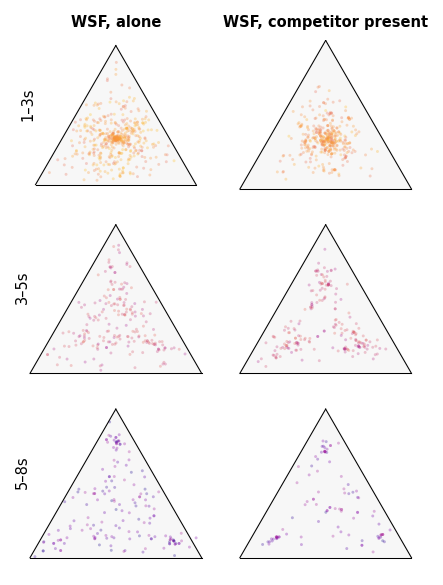

In [7]:
from matplotlib.colors import Normalize
def ylabel(label, ax):
    ax.text(0, 30, label, ha='right', va='center',  rotation=90, fontsize=7)

def compare_tempo_ranges_summary(**kwargs):
    kws = dict(
        norm=Normalize(0, 8), 
        ratios=False,
        plot_kws=dict(labels=False), 
        scatter_kws=dict(s=2, alpha=.3),
        cbar=False
    )
    fig, axs = plt.subplots(3, 2, figsize=(3, 4), tight_layout=True)
    ylabel('1–3s', axs[0, 0])
    show_row(axs[0, :], min_dur=1, max_dur=3, title=True, **kws)
    ylabel('3–5s', axs[1, 0])
    show_row(axs[1, :], min_dur=3, max_dur=5, **kws)
    ylabel('5–8s', axs[2, 0])
    show_row(axs[2, :], min_dur=5, max_dur=8, **kws)

compare_tempo_ranges_summary()
savefig('tempo-ranges-summary')


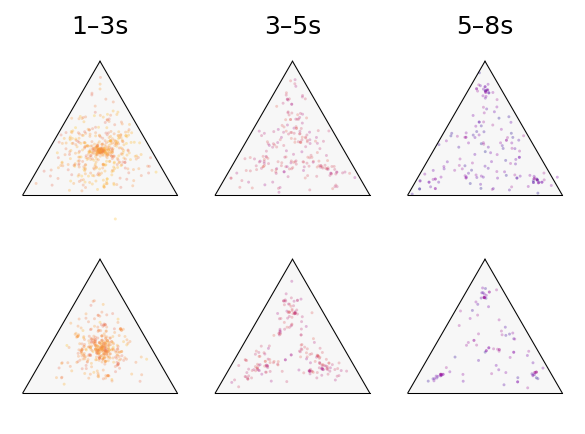

In [8]:
def compare_tempo_ranges_summary(**kwargs):
    kws = dict(
        norm=Normalize(0, 8), 
        ratios=False,
        plot_kws=dict(labels=False), 
        scatter_kws=dict(s=2, alpha=.3),
        cbar=False
    )
    fig, axs = plt.subplots(2, 3, figsize=(4, 3), tight_layout=True)
    axs[0, 0].set_title('1–3s')
    show_row(axs[:, 0], min_dur=1, max_dur=3, **kws)
    axs[0, 1].set_title('3–5s')
    show_row(axs[:, 1], min_dur=3, max_dur=5, **kws)
    axs[0, 2].set_title('5–8s')
    show_row(axs[:, 2], min_dur=5, max_dur=8, **kws)

compare_tempo_ranges_summary()
# savefig('tempo-ranges-summary')
